In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-payment-fraud-detection/onlinefraud.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
onlinefraud = pd.read_csv('/kaggle/input/online-payment-fraud-detection/onlinefraud.csv')
data_false_sample = onlinefraud[onlinefraud.isFraud==0].sample(frac=0.05, random_state=101)
data_true = onlinefraud[onlinefraud.isFraud==1]
onlinefraud = pd.concat([data_true, data_false_sample]).sort_index()

In [4]:
onlinefraud.describe().astype('int')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,325933,325933,325933,325933,325933,325933,325933,325933
mean,246,212298,864227,850231,1096629,1236803,0,0
std,145,755637,2940108,2938890,3394273,3700000,0,0
min,1,0,0,0,0,0,0,0
25%,156,13838,0,0,0,0,0,0
50%,249,79560,15914,0,123616,212834,0,0
75%,346,216526,123440,136190,928183,1114340,0,0
max,743,63294839,59585040,49585040,275405172,275277028,1,1


# Exploratory Data Analysis

In this EDA I sample 5% non fraud transaction because of Kaggle memory capacity. 6 Mio rows are too large for EDA and modeling in Kaggle Notebook.

Fraud transaction happened on 0.12% total transaction, after sampling 2.5% of total transactions. Due to sampling, I don't need to handle imbalance dataset. From EDA, I found that fraud transaction only happened in Cash Out and Transfer, I decided to remove other types of transaction from prediction and assume no fraud happened to other types transaction in the future.

In [5]:
onlinefraud.isFraud.value_counts(True)

isFraud
0    0.974802
1    0.025198
Name: proportion, dtype: float64

In [6]:
onlinefraud.isFlaggedFraud.value_counts()

isFlaggedFraud
0    325917
1        16
Name: count, dtype: int64

In [7]:
onlinefraud.type.value_counts()

type
CASH_OUT    115661
PAYMENT     107197
CASH_IN      70218
TRANSFER     30785
DEBIT         2072
Name: count, dtype: int64

In [8]:
categorical = ['type']
numerical_with_fe = ['amount', 'pctOrg', 'pctDest', 'transRatioDest', 'transRatioOrg']
numerical = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
target = 'isFraud'

In [9]:
onlinefraud['pctOrg'] = onlinefraud['newbalanceOrig']/onlinefraud['oldbalanceOrg'] - 1
onlinefraud['pctDest'] = onlinefraud['newbalanceDest']/onlinefraud['oldbalanceDest'] - 1

In [10]:
onlinefraud['transRatioDest'] = (onlinefraud['newbalanceDest'] + onlinefraud['oldbalanceDest'])/onlinefraud['amount']
onlinefraud['transRatioOrg'] = (onlinefraud['newbalanceOrig'] + onlinefraud['oldbalanceOrg'])/onlinefraud['amount']

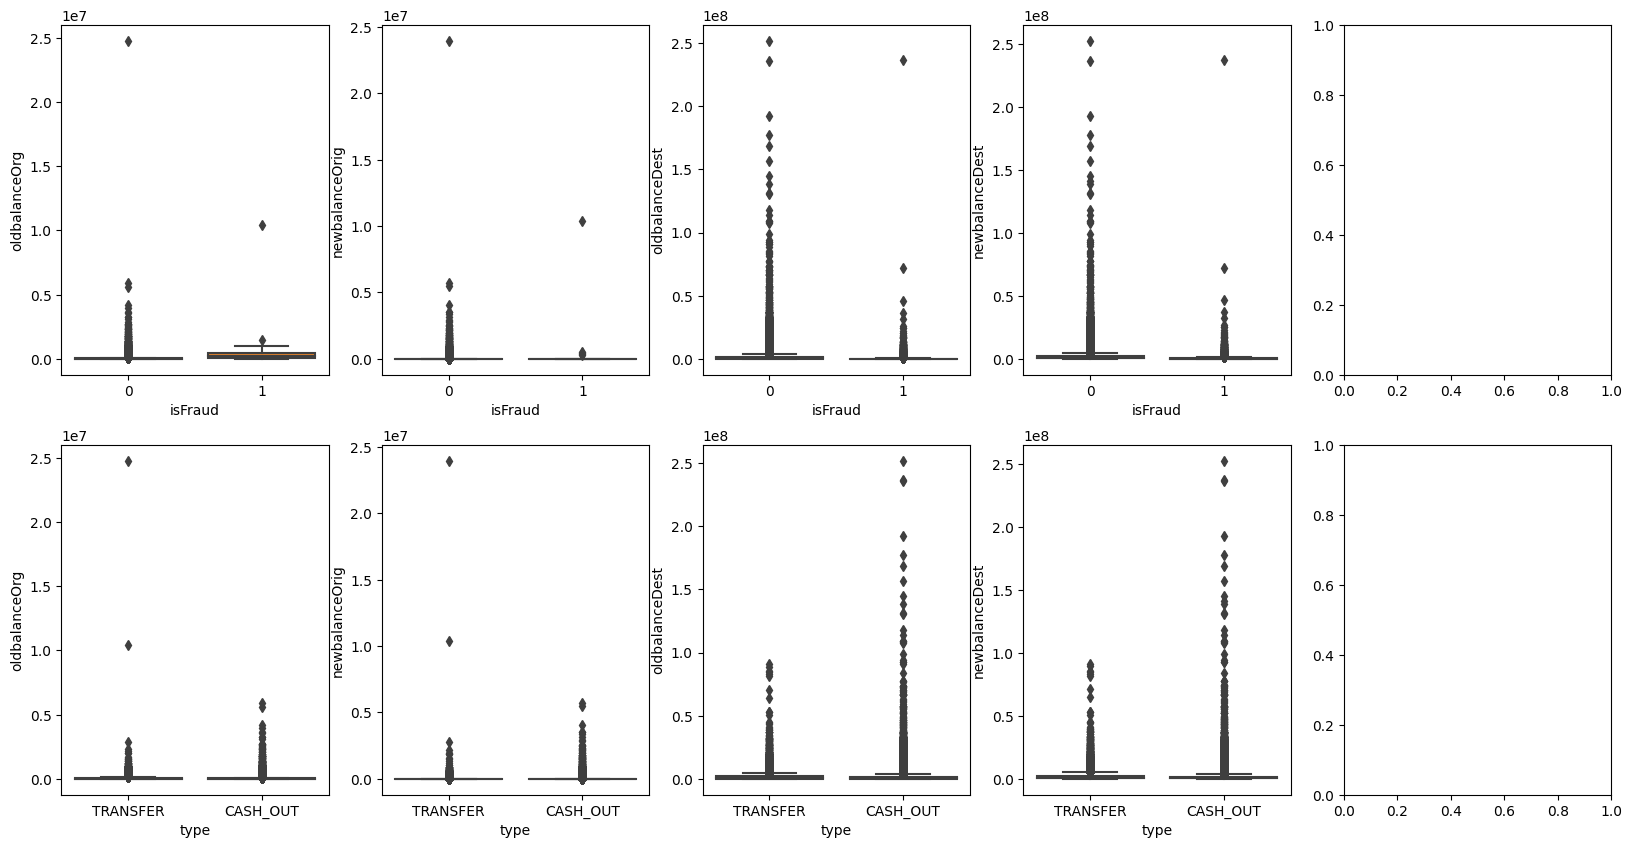

In [11]:
onlinefraud_filter = onlinefraud[(onlinefraud['type'].isin(['CASH_OUT', 'TRANSFER'])) & (onlinefraud['amount']<=1000000)]

fig, ax = plt.subplots(2,5, figsize=(20,10))

for i, col in enumerate(numerical):
    sns.boxplot(data = onlinefraud_filter , x= target, y=col, ax=ax[0, i])
    
for i, col in enumerate(numerical):
    sns.boxplot(data = onlinefraud_filter , x=categorical[0], y=col, ax=ax[1, i])

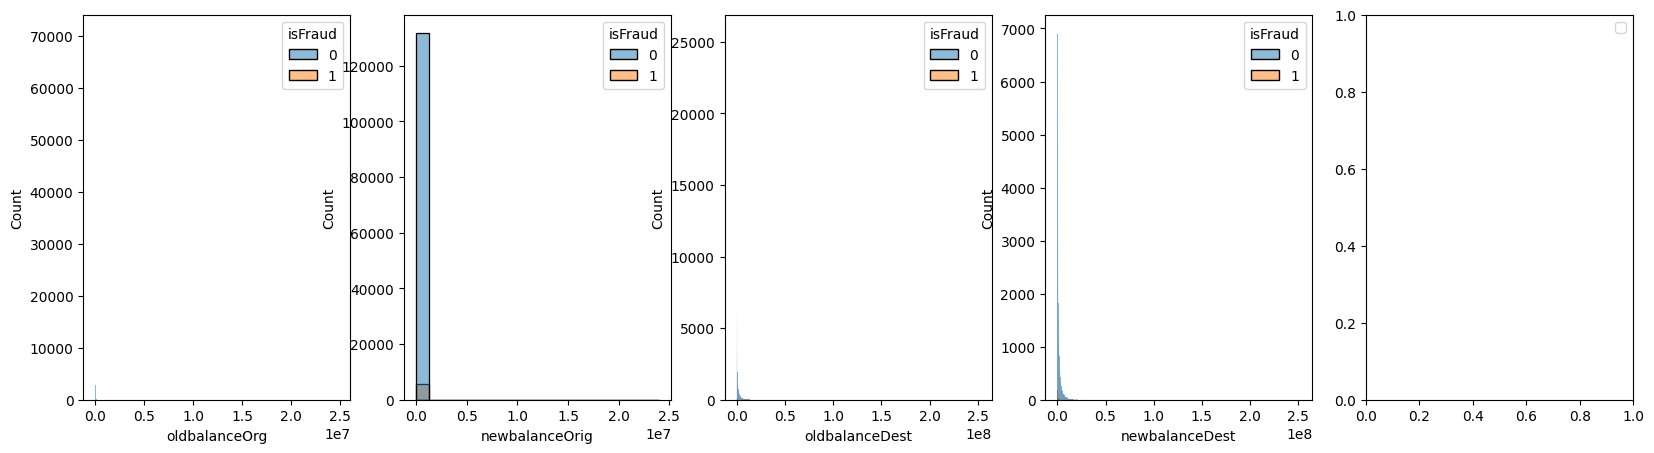

In [12]:
fig, ax = plt.subplots(1,5, figsize=(20,5))

for idx, col in enumerate(numerical):
    sns.histplot(data=onlinefraud_filter, x=col, hue="isFraud", ax=ax[idx])
    plt.legend()

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


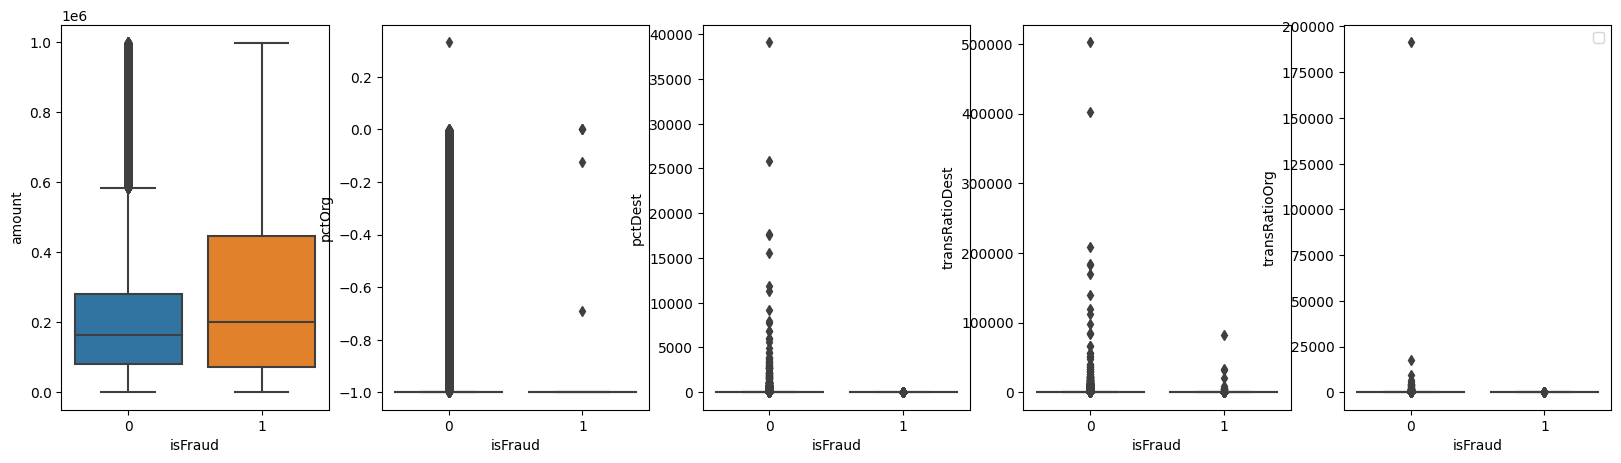

In [13]:
fig, ax = plt.subplots(1,5, figsize=(20,5))

for i, col in enumerate(numerical_with_fe):
    sns.boxplot(data = onlinefraud_filter , x= target, y=col, ax=ax[i])
    plt.legend()

<Axes: >

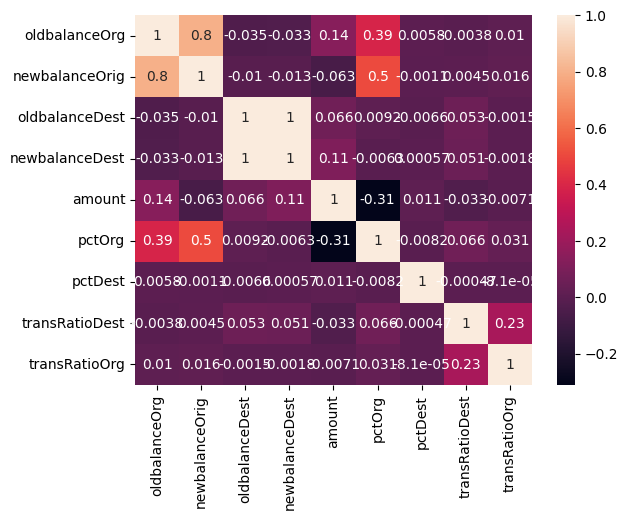

In [14]:
sns.heatmap(onlinefraud_filter[numerical + numerical_with_fe].corr(), annot=True)

In [15]:
onlinefraud[['type', 'isFraud']].value_counts()

type      isFraud
CASH_OUT  0          111545
PAYMENT   0          107197
CASH_IN   0           70218
TRANSFER  0           26688
CASH_OUT  1            4116
TRANSFER  1            4097
DEBIT     0            2072
Name: count, dtype: int64

In [16]:
onlinefraud[(onlinefraud['type'].isin(['CASH_OUT']))][['type', 'isFraud']].value_counts(normalize=True)

type      isFraud
CASH_OUT  0          0.964413
          1          0.035587
Name: proportion, dtype: float64

In [17]:
onlinefraud[(onlinefraud['type'].isin(['TRANSFER']))][['type', 'isFraud']].value_counts(normalize=True)

type      isFraud
TRANSFER  0          0.866916
          1          0.133084
Name: proportion, dtype: float64

In [18]:
onlinefraud_filter.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,pctOrg,pctDest,transRatioDest,transRatioOrg
count,137272.000000,137272.000000,1.372720e+05,1.372720e+05,1.372720e+05,1.372720e+05,137272.000000,137272.000000,75146.000000,1.344650e+05,1.372660e+05,137256.000000
mean,245.607903,211011.318593,5.230482e+04,1.529128e+04,1.536263e+06,1.758571e+06,0.040117,0.000022,-0.901482,inf,inf,3.545185
std,147.183670,183086.146549,1.530825e+05,1.099571e+05,3.698959e+06,3.741308e+06,0.196235,0.004675,0.242058,NaN,NaN,521.279789
min,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,-1.000000,-1.000000e+00,0.000000e+00,0.000000
25%,155.000000,79748.227500,0.000000e+00,0.000000e+00,1.008124e+05,2.924346e+05,0.000000,0.000000,-1.000000,8.454409e-02,2.656149e+00,0.000000
50%,237.000000,163820.410000,7.970000e+02,0.000000e+00,5.021660e+05,7.356855e+05,0.000000,0.000000,-1.000000,3.090265e-01,7.383291e+00,0.005605
75%,346.000000,285294.110000,3.866064e+04,0.000000e+00,1.563997e+06,1.855635e+06,0.000000,0.000000,-1.000000,1.044979e+00,2.373305e+01,0.287247
max,743.000000,999986.720000,2.477719e+07,2.397895e+07,2.519574e+08,2.523586e+08,1.000000,1.000000,0.331840,inf,inf,191391.248062


# Modeling

In [19]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

In [20]:
X = onlinefraud[numerical + categorical]
y = onlinefraud[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28, shuffle=True)

In [21]:
params = {'learning_rate': 0.1,'iterations': 50, 'depth': 16, 'l2_leaf_reg':0.1} 
cat_features = list(X_train.select_dtypes('O').columns)
# Initialize the CatBoostClassifier object  
# with the defined hyperparameters and fit it on the training set 
model = CatBoostClassifier(**params) 
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))

0:	learn: 0.6012965	test: 0.6012445	best: 0.6012445 (0)	total: 1.76s	remaining: 1m 26s
1:	learn: 0.5261588	test: 0.5260563	best: 0.5260563 (1)	total: 3.31s	remaining: 1m 19s
2:	learn: 0.4633852	test: 0.4632082	best: 0.4632082 (2)	total: 4.66s	remaining: 1m 13s
3:	learn: 0.4103704	test: 0.4102013	best: 0.4102013 (3)	total: 5.99s	remaining: 1m 8s
4:	learn: 0.3650574	test: 0.3648359	best: 0.3648359 (4)	total: 7.32s	remaining: 1m 5s
5:	learn: 0.3262551	test: 0.3259647	best: 0.3259647 (5)	total: 7.38s	remaining: 54.1s
6:	learn: 0.2925390	test: 0.2922083	best: 0.2922083 (6)	total: 8.71s	remaining: 53.5s
7:	learn: 0.2631829	test: 0.2628567	best: 0.2628567 (7)	total: 8.75s	remaining: 45.9s
8:	learn: 0.2373165	test: 0.2369796	best: 0.2369796 (8)	total: 10.1s	remaining: 45.9s
9:	learn: 0.2146426	test: 0.2142955	best: 0.2142955 (9)	total: 11.4s	remaining: 45.5s
10:	learn: 0.1945961	test: 0.1942063	best: 0.1942063 (10)	total: 12.7s	remaining: 45.1s
11:	learn: 0.1768214	test: 0.1764312	best: 0.1764

In [22]:
yhat = model.predict(X_val)
yhat_proba = model.predict_proba(X_val)

In [23]:
X_val['yhat'] = pd.Series(yhat, name="yhat", index=y_val.index)
X_val['yhat_proba'] = pd.Series(yhat_proba[:,1], name="yhat", index=y_val.index)
X_val['y'] = y_val

In [24]:
confusion_matrix(y_val, yhat)

array([[79404,    56],
       [  381,  1643]])

In [25]:
print(classification_report(y_val, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79460
           1       0.97      0.81      0.88      2024

    accuracy                           0.99     81484
   macro avg       0.98      0.91      0.94     81484
weighted avg       0.99      0.99      0.99     81484



In [26]:
precision, recall, thresholds = precision_recall_curve(y_val, yhat_proba[:,1])

In [27]:
precision_recall_curve = pd.DataFrame({'thresholds':thresholds,'precision': precision[:-1], 'recall':recall[:-1]})

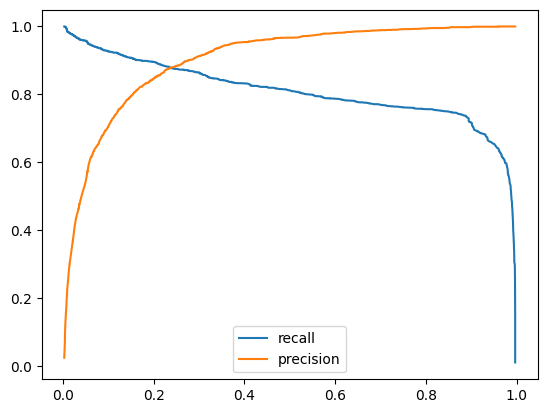

In [28]:
plt.plot(thresholds, recall[:-1], label='recall')
plt.plot(thresholds, precision[:-1], label = 'precision')
plt.legend()

In [29]:
precision_recall_curve[precision_recall_curve['precision']<=precision_recall_curve['recall']]

,thresholds,precision,recall
0,0.003193,0.024839,1.000000
1,0.003215,0.024840,1.000000
2,0.003220,0.024840,1.000000
3,0.003221,0.024840,1.000000
4,0.003221,0.024840,1.000000
...,...,...,...
31633,0.232110,0.874939,0.881423
31634,0.234018,0.875368,0.881423
31635,0.234425,0.875798,0.881423
31636,0.234497,0.875737,0.880929


Since fraud detection is important and I assume we don't want to detect Fraud as Non Fraud, then we can focus on Recall. From the precision recall curve above, the balance score happened when threshold is set to 0.234 with 0.88 Recall score which is so good.

In [30]:
X_val['yhat'] = 0
X_val.loc[X_val['yhat_proba']>=0.234, 'yhat']=1

# Gain Curve

In [31]:
X_val['decile'] = pd.qcut(X_val['yhat_proba'], 10, labels=[i for i in range (10, 0, -1)])

In [32]:
gain_table = X_val.groupby('decile').agg(num_cases=('type', 'count'), num_of_resp=('y', 'sum')).reset_index().sort_values('decile', ascending=False).reset_index(drop=True)

In [33]:
gain_table['cumsum_resp'] = gain_table['num_of_resp'].cumsum()

In [34]:
gain_table['perc_of_events'] = round(gain_table['num_of_resp']/gain_table['num_of_resp'].sum() * 100, 2)

In [35]:
gain_table['gain'] = gain_table['perc_of_events'].cumsum()

In [36]:
gain_table['num_cases_cumsum'] = gain_table['num_cases'].cumsum()

In [37]:
gain_table.columns

Index(['decile', 'num_cases', 'num_of_resp', 'cumsum_resp', 'perc_of_events',
       'gain', 'num_cases_cumsum'],
      dtype='object')

In [38]:
gain_table = pd.concat([pd.DataFrame({'decile':0, 'num_cases':0, 'num_of_resp':0, 'cumsum_resp':0, 'perc_of_events':0,
       'gain':0, 'num_cases_cumsum':0}, index=[0]), gain_table])

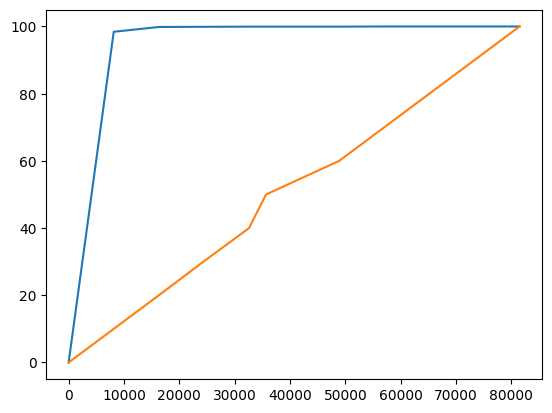

In [39]:
plt.plot(gain_table['num_cases_cumsum'], gain_table['gain'])
plt.plot(gain_table['num_cases_cumsum'], range(0, 101, 10))

In [40]:
gain_table

,decile,num_cases,num_of_resp,cumsum_resp,perc_of_events,gain,num_cases_cumsum
0,0,0,0,0,0.00,0.00,0
0,1,8149,1992,1992,98.42,98.42,8149
1,2,8147,29,2021,1.43,99.85,16296
2,3,8055,1,2022,0.05,99.90,24351
3,4,8243,1,2023,0.05,99.95,32594
4,5,3079,0,2023,0.00,99.95,35673
5,6,13217,0,2023,0.00,99.95,48890
6,7,8149,1,2024,0.05,100.00,57039
7,8,8147,0,2024,0.00,100.00,65186
8,9,8149,0,2024,0.00,100.00,73335
